In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import os, time
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

import PIL.Image as pi
import matplotlib.pyplot as plt
    

from dataset import get_datasets, eva_dataset
from function import QD, make_tif, get_month_img

In [2]:
# parameters for network
num_in = 3
num_out = 1

# parameters for training
batch_size = 64
num_workers = 0
use_cuda = torch.cuda.is_available()
num_epochs = 1000

# dataset location
#  train_path: .csv, in-situ concentration and related variables for training
#  DEM_path: .tif, DEM data
#  VCD_path: .tif, VCD data
train_path = "fullset.csv"
DEM_path = "DEM.tif"
VCD_path = "VCD.tif"

# ratio of testing set
test_size = 0.1

# output filefolder location
output_path = r"C:\Users\Ding\Desktop"# your output dir

In [3]:
class MLP(nn.Module):
    def __init__(self, num_in, num_out):
        super(MLP, self).__init__()
        self.bn1 = nn.BatchNorm1d(num_in)
        self.fc1 = nn.Linear(num_in, 50)
        
        self.bn2 = nn.BatchNorm1d(50)
        self.fc2 = nn.Linear(50, 50)
        
        self.bn3 = nn.BatchNorm1d(50)
        self.fc3 = nn.Linear(50, num_out)

    def forward(self, x):
        x = self.bn1(x)
        x = self.fc1(x)
        x = F.relu(x, inplace=True)
        
        x = self.bn2(x)
        x = self.fc2(x)
        x = F.relu(x, inplace=True)
        
        x = self.bn3(x)
        x = self.fc3(x)
        
        return x

In [4]:
training_set, testing_set, y_scaler = get_datasets(train_path, test_size)  

training_loader = DataLoader(training_set, 
                             shuffle=True, 
                             batch_size=batch_size, 
                             num_workers=num_workers
                            )
testing_loader = DataLoader(testing_set, 
                            shuffle=True, 
                            batch_size=batch_size, 
                            num_workers=num_workers
                           )

In [5]:
net = MLP(num_in, num_out)
criterion = nn.L1Loss()
optimizer = optim.SGD(net.parameters(), lr=0.005)

losses = []

In [6]:
net.train()
start = time.time()
for epoch in tqdm(range(num_epochs)):
    epoch_loss = []
    for idx, (x, y) in enumerate(training_loader):
        
        x = x.view(-1,num_in).float()
        y = y.view(-1, 1).float()
        
        if use_cuda:
            x, y = x.cuda(), y.cuda()
            
        optimizer.zero_grad()

        pred = net(x)
        
        loss = criterion(pred, y)
            
        loss.backward()
        epoch_loss.append(loss.item())
        optimizer.step()
        
    losses.extend(epoch_loss)
    
print('training time:', time.time()-start)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:11<00:00,  3.21it/s]

training time: 311.4662058353424


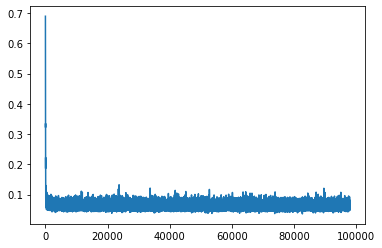

In [7]:
plt.plot(losses)
plt.show()

In [8]:
def predict(net, loader):
    P = np.zeros((0))
    real = np.zeros((0))
    
    net.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.view(-1, num_in).float()
        y = y.view(-1).float()
        if use_cuda:
            x, y = x.cuda(), y.cuda()
        p = net(x)
        
        
        P = np.hstack((P, p.data.cpu().numpy().reshape(-1)))
        real = np.hstack((real, y.data.cpu().numpy().reshape(-1)))
        
    return real, P

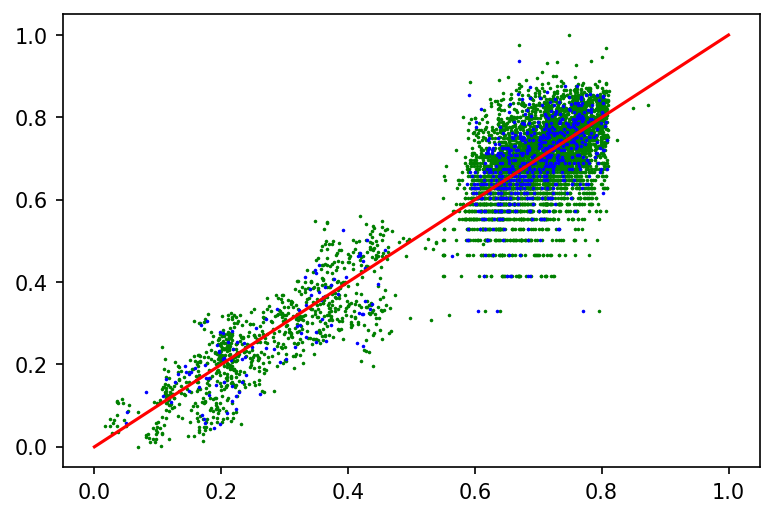

In [9]:
y_train, hat_y_train = predict(net, training_loader)
y_test, hat_y_test = predict(net, testing_loader)

plt.figure(dpi=150)
plt.scatter(hat_y_train,y_train,s=0.5,c="g")
plt.scatter(hat_y_test,y_test,s=0.5,c="b")
plt.plot([0,1],[0,1],"r-")
plt.show()

In [10]:
img, zero_tag = get_month_img(DEM_path, VCD_path)

In [11]:
n = 100
sec_length = int(3600*7200/n)

torch.set_num_threads(8)
with torch.no_grad():
    pp = np.zeros((0))
    net.eval()

    for i in tqdm(range(n)):

        P = net(torch.tensor(img[int(i*sec_length):int((i+1)*sec_length)]).view(-1,num_in).float())
        P = P.data.cpu().numpy()
              
        p = y_scaler.inverse_transform(P.reshape(-1,1)).reshape(1,-1)[0]  
        pp = np.hstack((pp, p))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.33it/s]


Succeeded in generating point estimation.tif :)


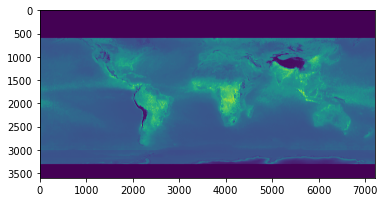

In [12]:
# point estimation
P_data_map=-(np.exp(pp).reshape(-1)*(zero_tag-1)).reshape(3600, 7200)
make_tif("point estimation", P_data_map, output_path) # nmol/L
plt.imshow(P_data_map)
plt.show()

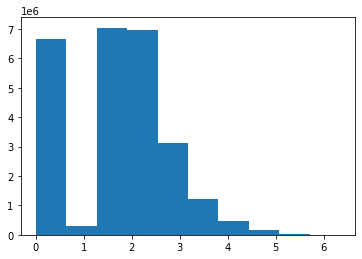

In [13]:
plt.hist(P_data_map.reshape(-1))
plt.show()